Generating the real A is working, the problem now is getting the algorithm to work

Smooth is not working yet

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage.color import rgb2gray
from skimage.transform import rescale
from numpy.fft import fft2, ifft2
import h5py
from scipy.linalg import sqrtm, inv
from tqdm import tqdm
from PIL import Image

In [2]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

def plot_data(x):
    plt.imshow(x, cmap='gray')
    plt.title("X")
    plt.axis('off')
    plt.show()

In [3]:
def bwgd(y, A, niter=30, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/2 - np.exp(-y / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde
   
    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde
           
    for iter in tqdm(range(1, niter)):
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ (x_tilde+1e-10) 
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
        x_tilde -= np.linalg.solve(hessian, gradient)

        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [61]:
def bwgd_complex(y, A, niter=30, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ np.conj(A).T/ n
    C_sqrt = sqrtm(C)
    C_inv = inv(C_sqrt)
    A_tilde = C_inv @ A

    # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/2 - np.exp(-y / lambda_sq)) ) @ np.conj(A_tilde).T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ np.conj(A_tilde).T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde
   
    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde
           
    for iter in range(1, niter):
        hessian = (A_tilde @ np.conj(A_tilde).T) / n
        
        # Gradient
        At_x = np.conj(A_tilde).T @ (x_tilde+1e-10)  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
        x_tilde -= np.linalg.solve(hessian, gradient)

        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [5]:
def bwgd_smooth(y, A, niter=30, gamma=0.01, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @  np.conj(A).T / n
    C_sqrt = sqrtm(C)
    C_inv = inv(C_sqrt)
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y**2)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @  np.conj(A_tilde).T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ np.conj(A_tilde).T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde

    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde


    for iter in range(1, niter):
        loss_values = (np.abs(np.conj(A_tilde).T @ x_tilde) - y) ** 2
        epsilon = np.quantile(loss_values, gamma)

        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt((np.conj(A_tilde).T @ x_tilde)**2 + epsilon*np.sum(A_tilde**2, axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1/n) * A_tilde @ (alpha * (np.conj(A_tilde).T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [6]:
# Loading the data
def load_v73_mat(filepath, variable_name):
    with h5py.File(filepath, 'r') as f:
        data = f[variable_name][()]  # Get raw HDF5 data
        data = np.array(data).T      # Transpose to match MATLAB's column-major order
    return data

In [7]:
n1, n2, L = 16, 16, 21  # Use very small sizes due to memory constraints
# Create dummy image I and masks
I = np.random.randn(n1, n2)
Masks = np.random.choice([1j, -1j, 1, -1], size=(n1, n2, L))
mag = np.where(np.random.rand(n1, n2, L) <= 0.2, np.sqrt(3), 1 / np.sqrt(2))
Masks *= mag

# A(I) = FFT2(conj(Masks) * I), repeated over L masks
def A_func(I):
    return fft2(np.conj(Masks) * np.repeat(I[:, :, None], L, axis=2))

# Construct an actual matrix A
def construct_A_matrix(n1, n2, L, Masks):
    N = n1 * n2
    A_matrix = np.zeros((N * L, N), dtype=np.complex128)
    eye = np.eye(N)
    for i in range(N):
        e_i = eye[:, i].reshape(n1, n2)
        Ae = A_func(e_i)  # shape (n1, n2, L)
        A_matrix[:, i] = Ae.transpose(2, 0, 1).reshape(-1)
    return A_matrix

# Build the matrix
A_mat = construct_A_matrix(n1, n2, L, Masks)

# Test the matrix
I_vec = I.flatten()
A_vec = A_func(I).transpose(2, 0, 1).reshape(-1)
A_mat_I = A_mat @ I_vec

# Compare outputs
print("Difference of A(I) and A_mat @ I:", np.linalg.norm(A_vec - A_mat_I))

# Test the matrix
#A_vec = A_func(x_true.reshape(n1,n2)).transpose(2, 0, 1).reshape(-1)
#A_mat_I = A_mat @ x_true
#print("Difference of A(x) and A_mat @ x:", np.linalg.norm(A_vec - A_mat_I))

Difference of A(I) and A_mat @ I: 3.047646466650895e-13


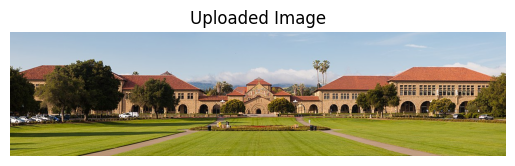

(300, 1200, 3)

In [33]:
# Load the image
stanford = 'stanford.jpg'  
image = Image.open(image_path)
image_np = np.array(image)

plt.imshow(image_np[:,:,:])
plt.axis('off')  # Hide axis
plt.title('Uploaded Image')
plt.show()
image_np.shape

In [36]:
A = construct_A_matrix(300, 1200, 1, Masks)
for i in range(3):
    x_true = image_np[:, :, i]
    y = (np.abs(A @ x_true))  # shape (21 * 256,)
    
    # Run your algorithm
    x_hat, iters = bwgd_smooth(y, A.T, init="spec2")
        
    # Compute alignment-invariant error
    error = []
    for xi in x_hat:
        error.append(np.linalg.norm((np.abs(A@xi))-y))
    
    plot_data(x_hat[-1].reshape(16, 16))
        
    # Plot error per iteration
    plt.plot(error, label=f"Trial {i+1}")
    plt.xlabel("Iteration")
    plt.ylabel("Error (log)")
    plt.yscale('log')  
    plt.title("Real-World Data")
    plt.legend()
    plt.show()

MemoryError: Unable to allocate 1.89 TiB for an array with shape (360000, 360000) and data type complex128

C:\Users\gabreu\AppData\Local\Temp\ipykernel_19448\3110892481.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  x[0] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_19448\3110892481.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  x[iter] = C_inv @ x_tilde


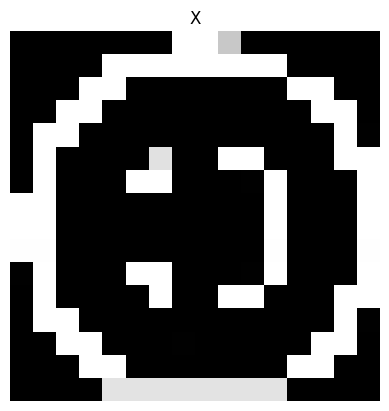

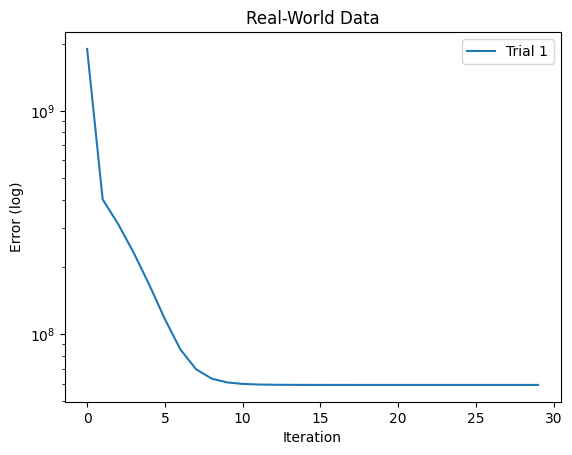

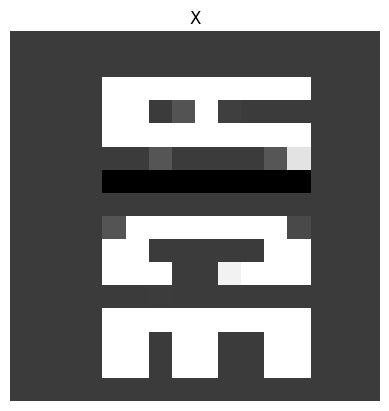

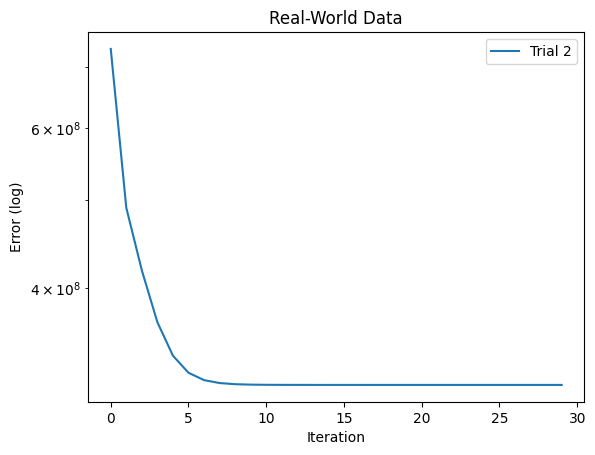

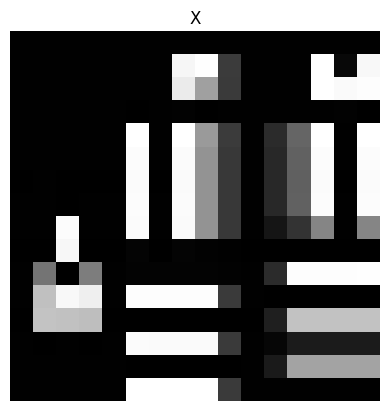

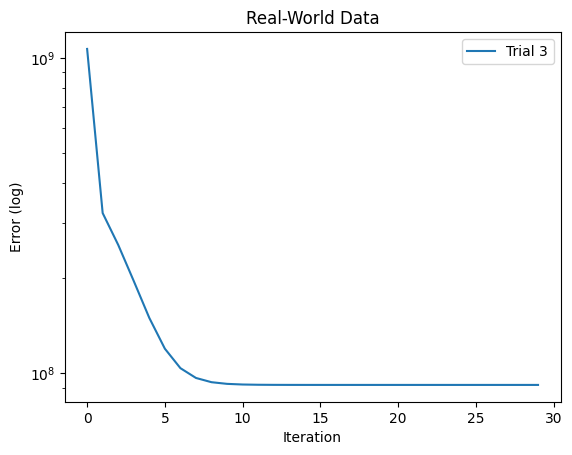

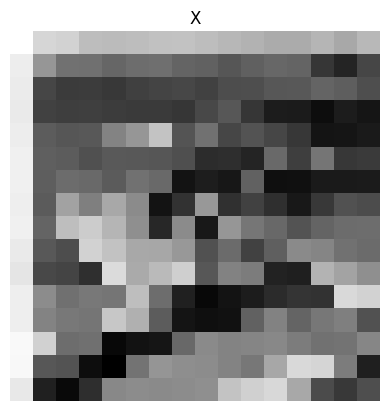

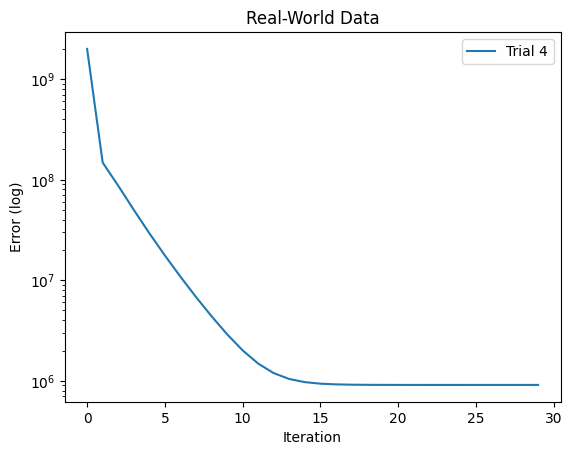

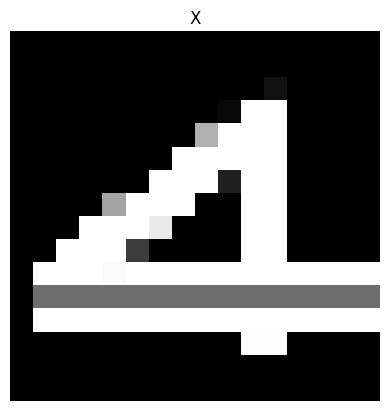

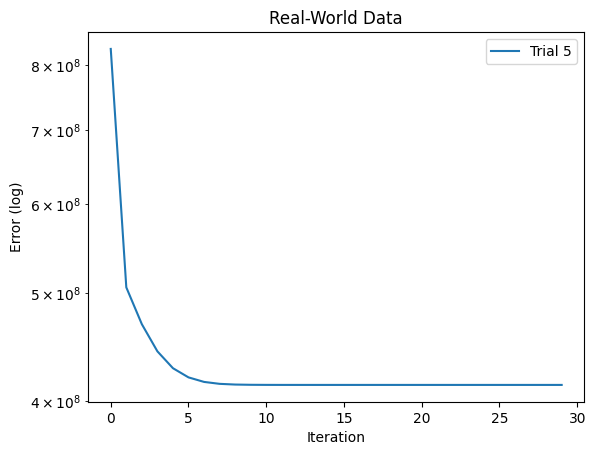

In [62]:
# Load Data and generate data
XH = load_v73_mat('AmpSLM_16x16/XH_test.mat', 'XH_test')
A = construct_A_matrix(16, 16, 21, Masks)
for i in range(5):
    x_true = XH[i, :]
    y = np.abs(A @ x_true)**2  # shape (21 * 256,)
    
    # Run your algorithm
    x_hat, iters = bwgd_complex(y, A.T, init="spec2")
        
    # Compute alignment-invariant error
    error = []
    for xi in x_hat:
        error.append(np.linalg.norm((np.abs(A@xi))**2-y))
    
    plot_data(x_hat[-1].reshape(16, 16))
        
    # Plot error per iteration
    plt.plot(error, label=f"Trial {i+1}")
    plt.xlabel("Iteration")
    plt.ylabel("Error (log)")
    plt.yscale('log')  
    plt.title("Real-World Data")
    plt.legend()
    plt.show()

In [56]:
np.linalg.norm(x_true-x_hat[-1])

563.4593927041585

In [57]:
x_true

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  18,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   8, 255, 255,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 177, 255, 255, 255,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255,
       255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1, 255, 255,
       255,  32, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0, 164,
       255, 255, 255,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,
         0, 255, 255, 255, 234,   0,   0,   0, 255, 255,   0,   0,   0,
         0,   0,   0, 255, 255, 255,  60,   0,   0,   0,   0, 255, 255,
         0,   0,   0,   0,   0, 255, 255, 255, 251, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 25

In [58]:
xi

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.10319375e-04,  9.90269764e-04, -6.50489200e-05,  8.43957726e-03,
        1.54030845e-04,  8.71826578e-04,  2.43643038e-04, -3.86232852e-06,
       -2.63688434e-05,  2.18489307e-05,  4.50095223e-04,  1.75855986e+01,
       -6.26803811e-04, -5.73381399e-04,  4.07247021e-05,  8.90093110e-06,
        1.02245575e-03,  4.98201371e-04, -2.26146191e-04, -5.25489599e-04,
        2.33119662e-04,  

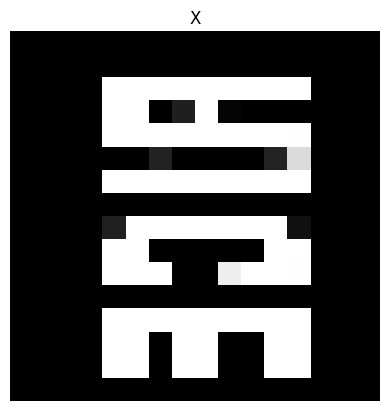

In [43]:
# Pick a test index
plot_data(XH[1, :].reshape(n1,n2))